In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_openml


In [2]:
import os, certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
df = fetch_openml(name='Boston', version=1, as_frame=True)
X = df.data.copy()
y = df.target.copy()

In [3]:
X.columns = [
    'CRIME_RATE', 'GREEN_AREA', 'INDUSTRIAL_AREA', 'RIVER_PROXIMITY',
    'POLLUTION_LEVEL', 'AVG_ROOMS', 'HOUSE_AGE', 'EMPLOYMENT_DISTANCE',
    'LOCALITY_RANK', 'PROPERTY_TAX', 'TEACHER_RATIO', 'MIGRANT_POPULATION', 'LOW_INCOME_POP'
]

In [4]:
# Convert target to lakhs INR
y = y * 75 / 10

In [5]:
print("Step 1: Dataset loaded and features renamed for Bhubaneswar")
print(f"Features: {X.columns.tolist()}")
print(f"Target range: ₹{y.min():.2f} lakhs to ₹{y.max():.2f} lakhs")

Step 1: Dataset loaded and features renamed for Bhubaneswar
Features: ['CRIME_RATE', 'GREEN_AREA', 'INDUSTRIAL_AREA', 'RIVER_PROXIMITY', 'POLLUTION_LEVEL', 'AVG_ROOMS', 'HOUSE_AGE', 'EMPLOYMENT_DISTANCE', 'LOCALITY_RANK', 'PROPERTY_TAX', 'TEACHER_RATIO', 'MIGRANT_POPULATION', 'LOW_INCOME_POP']
Target range: ₹37.50 lakhs to ₹375.00 lakhs


In [6]:
print("\nStep 2: Handling missing values...")
print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")


Step 2: Handling missing values...
Missing values in features: 0
Missing values in target: 0


In [7]:
# If there were missing values, we would use:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='median')
# X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


In [11]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(df, columns=None, coerce_numeric=False, iqr_multiplier=1.5, verbose=True):
    """
    Remove rows that are outliers based on IQR for numeric columns.
    - df: pandas DataFrame
    - columns: list of column names to check. If None, will use numeric columns only.
    - coerce_numeric: if True, try pd.to_numeric on non-numeric cols (errors='coerce') before checking.
    - iqr_multiplier: multiplier for the IQR rule (1.5 typical)
    Returns: cleaned_df (a copy) -- rows removed are dropped.
    """
    # Work on a copy
    clean_df = df.copy()

    # If user did not pass columns, pick numeric columns
    if columns is None:
        numeric_cols = clean_df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        numeric_cols = list(columns)

    # Optionally attempt to coerce some columns to numeric
    if coerce_numeric:
        for col in numeric_cols:
            if not pd.api.types.is_numeric_dtype(clean_df[col]):
                clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')

    # Final filter: keep only numeric columns for IQR checks
    numeric_cols = [c for c in numeric_cols if pd.api.types.is_numeric_dtype(clean_df[c])]
    if verbose:
        print(f"Columns to use for IQR outlier removal: {numeric_cols}")

    # If no numeric columns, nothing to do
    if not numeric_cols:
        if verbose:
            print("No numeric columns found — returning original df")
        return clean_df

    # Build boolean mask of rows to KEEP (start as all True)
    keep_mask = pd.Series(True, index=clean_df.index)

    # Apply IQR rule column by column
    for col in numeric_cols:
        series = clean_df[col].dropna()  # compute quantiles on non-null values
        if series.empty:
            if verbose:
                print(f"Column {col} is empty after dropping NA — skipping.")
            continue

        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        # Rows that are NOT outliers for this column
        col_mask = (clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)

        # Count outliers before applying
        outliers_before = (~col_mask & ~clean_df[col].isna()).sum()
        if verbose:
            print(f"{col}: Q1={Q1:.4g}, Q3={Q3:.4g}, IQR={IQR:.4g}, lower={lower_bound:.4g}, upper={upper_bound:.4g}, outliers={outliers_before}")

        # Combine masks (row must be non-outlier for all considered numeric columns)
        keep_mask &= col_mask.fillna(True)  # treat NaN as not failing bounds (optional choice)

    # Apply final mask
    cleaned = clean_df.loc[keep_mask].copy()
    if verbose:
        print(f"Rows before: {len(df)}, rows after: {len(cleaned)}, rows removed: {len(df) - len(cleaned)}")

    return cleaned


In [12]:
# Remove outliers from features
X_clean = remove_outliers_iqr(X, X.columns)
y_clean = y.loc[X_clean.index]

print(f"Original data shape: {X.shape}")
print(f"After outlier removal: {X_clean.shape}")
print(f"Rows removed: {X.shape[0] - X_clean.shape[0]}")

# Step 4: Handle capped target variable
print("\nStep 4: Handling capped target variable...")
target_cap = y_clean.max()
capped_count = (y_clean == target_cap).sum()
print(f"Target is capped at: ₹{target_cap:.2f} lakhs")
print(f"Number of capped values: {capped_count}")

Columns to use for IQR outlier removal: ['CRIME_RATE', 'GREEN_AREA', 'INDUSTRIAL_AREA', 'POLLUTION_LEVEL', 'AVG_ROOMS', 'HOUSE_AGE', 'EMPLOYMENT_DISTANCE', 'PROPERTY_TAX', 'TEACHER_RATIO', 'MIGRANT_POPULATION', 'LOW_INCOME_POP']
CRIME_RATE: Q1=0.08204, Q3=3.677, IQR=3.595, lower=-5.311, upper=9.07, outliers=66
GREEN_AREA: Q1=0, Q3=12.5, IQR=12.5, lower=-18.75, upper=31.25, outliers=68
INDUSTRIAL_AREA: Q1=5.19, Q3=18.1, IQR=12.91, lower=-14.18, upper=37.47, outliers=0
POLLUTION_LEVEL: Q1=0.449, Q3=0.624, IQR=0.175, lower=0.1865, upper=0.8865, outliers=0
AVG_ROOMS: Q1=5.885, Q3=6.623, IQR=0.738, lower=4.778, upper=7.731, outliers=30
HOUSE_AGE: Q1=45.02, Q3=94.07, IQR=49.05, lower=-28.55, upper=167.6, outliers=0
EMPLOYMENT_DISTANCE: Q1=2.1, Q3=5.188, IQR=3.088, lower=-2.532, upper=9.821, outliers=5
PROPERTY_TAX: Q1=279, Q3=666, IQR=387, lower=-301.5, upper=1246, outliers=0
TEACHER_RATIO: Q1=17.4, Q3=20.2, IQR=2.8, lower=13.2, upper=24.4, outliers=15
MIGRANT_POPULATION: Q1=375.4, Q3=396.2,

In [13]:
if capped_count / len(y_clean) < 0.05:
    uncapped_mask = y_clean < target_cap
    X_clean = X_clean[uncapped_mask]
    y_clean = y_clean[uncapped_mask]
    print(f"Removed {capped_count} capped values")
else:
    print("Too many capped values - keeping them for now")

Removed 5 capped values


In [14]:
print("\nStep 5: Creating bins for stratified splitting...")
y_bins = pd.cut(y_clean, bins=5, labels=False)
print("Target value ranges for each bin:")
for i in range(5):
    bin_mask = (y_bins == i)
    if bin_mask.any():
        bin_min = y_clean[bin_mask].min()
        bin_max = y_clean[bin_mask].max()
        print(f"  Bin {i}: ₹{bin_min:.2f} - ₹{bin_max:.2f} lakhs")



Step 5: Creating bins for stratified splitting...
Target value ranges for each bin:
  Bin 0: ₹63.75 - ₹120.75 lakhs
  Bin 1: ₹121.50 - ₹177.75 lakhs
  Bin 2: ₹178.50 - ₹225.75 lakhs
  Bin 3: ₹236.25 - ₹284.25 lakhs
  Bin 4: ₹309.75 - ₹350.25 lakhs


In [15]:
print("\nStep 6: Performing stratified train-test split...")
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, 
    test_size=0.2, 
    random_state=42,
    stratify=y_bins  # Use bins for stratification
)


Step 6: Performing stratified train-test split...


In [16]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 234
Testing set size: 59


In [17]:
print("\nStep 7: Normalizing the data...")
from sklearn.preprocessing import StandardScaler



Step 7: Normalizing the data...


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Only transform test data, don't fit

print("Data normalized using StandardScaler (mean=0, std=1)")


Data normalized using StandardScaler (mean=0, std=1)


In [19]:
print("\nStep 8: Performing cross-validation with K-Fold...")
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Step 8: Performing cross-validation with K-Fold...


In [20]:
models = {
    'Linear Regression': LinearRegression(),
}

# Set up K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each model
cv_results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=kfold, scoring='r2')
    
    cv_results[name] = {
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'cv_scores': cv_scores
    }
    
    print(f"  Cross-validation R² scores: {cv_scores}")
    print(f"  Mean R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")



Evaluating Linear Regression...
  Cross-validation R² scores: [0.76479005 0.77751055 0.63302993 0.6637966  0.7674763 ]
  Mean R²: 0.7213 (±0.0605)


In [21]:
print("\nStep 9: Training the best model on entire training set...")
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['cv_r2_mean'])
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")

# Train the best model on entire training data
best_model.fit(X_train_scaled, y_train)

# Step 10: FINAL TESTING - Only now use the test data
print("\nStep 10: FINAL TESTING on unseen test data...")


Step 9: Training the best model on entire training set...
Best model: Linear Regression

Step 10: FINAL TESTING on unseen test data...


In [22]:
y_pred = best_model.predict(X_test_scaled)

# Calculate evaluation metrics
test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

# Adjusted R²
n_test = len(X_test)
p_test = X_test.shape[1]
test_adj_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

In [23]:
print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE ON TEST DATA")
print("="*50)
print(f"Mean Absolute Error: ₹{test_mae:.2f} lakhs")
print(f"Mean Squared Error: {test_mse:.2f}")
print(f"Root Mean Squared Error: ₹{test_rmse:.2f} lakhs")
print(f"R² Score: {test_r2:.4f}")
print(f"Adjusted R²: {test_adj_r2:.4f}")


FINAL MODEL PERFORMANCE ON TEST DATA
Mean Absolute Error: ₹18.52 lakhs
Mean Squared Error: 554.50
Root Mean Squared Error: ₹23.55 lakhs
R² Score: 0.6147
Adjusted R²: 0.5034



Step 11: Creating visualizations...


Text(0.5, 1.0, 'Actual vs Predicted Prices')

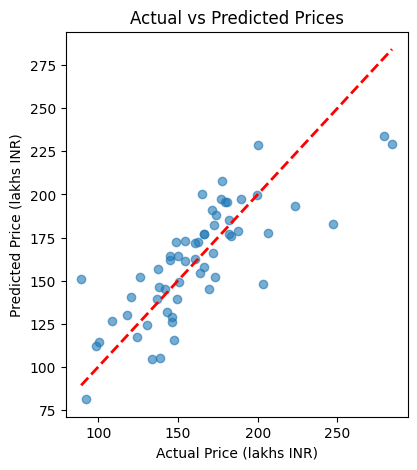

In [24]:
print("\nStep 11: Creating visualizations...")

plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (lakhs INR)')
plt.ylabel('Predicted Price (lakhs INR)')
plt.title('Actual vs Predicted Prices')


Text(0.5, 1.0, 'Residual Plot')

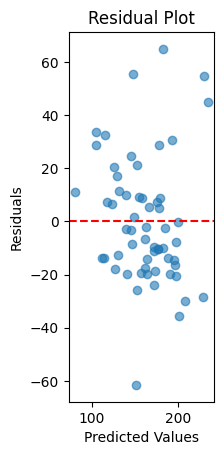

In [25]:
residuals = y_test - y_pred
plt.subplot(1, 3, 2)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

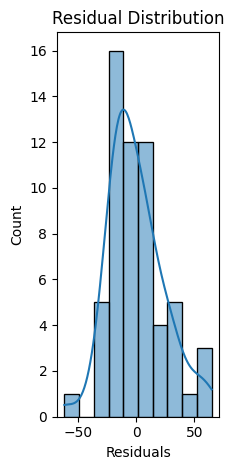

In [26]:
plt.subplot(1, 3, 3)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residual Distribution')

plt.tight_layout()
plt.show()

In [27]:
print("\nStep 12: Feature Importance Analysis")
if hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': X_clean.columns,
        'Importance': abs(best_model.coef_)
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (Absolute Coefficients):")
    for _, row in feature_importance.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")

# Step 13: Save the final model and preprocessing objects
print("\nStep 13: Saving the final model...")


Step 12: Feature Importance Analysis

Feature Importance (Absolute Coefficients):
  AVG_ROOMS: 19.2943
  LOCALITY_RANK: 18.2501
  PROPERTY_TAX: 13.7391
  CRIME_RATE: 12.1981
  EMPLOYMENT_DISTANCE: 12.0595
  HOUSE_AGE: 10.2663
  TEACHER_RATIO: 9.6465
  LOW_INCOME_POP: 8.3030
  POLLUTION_LEVEL: 3.1510
  RIVER_PROXIMITY: 3.1292
  MIGRANT_POPULATION: 1.7735
  GREEN_AREA: 1.2176
  INDUSTRIAL_AREA: 0.4432

Step 13: Saving the final model...


In [28]:
import pickle

# Save scaler
pickle.dump(scaler, open('bhubaneswar_scaler.pkl', 'wb'))

# Save model
pickle.dump(best_model, open('bhubaneswar_best_model.pkl', 'wb'))

print("Model and scaler saved successfully!")

# Step 14: Create prediction function for new data
print("\nStep 14: Creating prediction function...")


Model and scaler saved successfully!

Step 14: Creating prediction function...


In [29]:
def predict_bhubaneswar_house_price(features_dict):
    """
    Predict house price for Bhubaneswar using the trained model
    """
    try:
        # Load model and scaler
        model = pickle.load(open('bhubaneswar_best_model.pkl', 'rb'))
        scaler = pickle.load(open('bhubaneswar_scaler.pkl', 'rb'))
        
        # Convert to DataFrame
        input_df = pd.DataFrame([features_dict])
        
        # Ensure correct column order
        input_df = input_df[X_clean.columns]
        
        # Scale features
        scaled_input = scaler.transform(input_df)
        
        # Predict
        prediction = model.predict(scaled_input)
        
        return prediction[0]
    
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None

In [30]:
sample_house = {
    'CRIME_RATE': 0.1,
    'GREEN_AREA': 18.0,
    'INDUSTRIAL_AREA': 2.0,
    'RIVER_PROXIMITY': 1,  # Near Kuakhai River
    'POLLUTION_LEVEL': 0.4,
    'AVG_ROOMS': 6.5,      # Good number of rooms
    'HOUSE_AGE': 45.0,     # Moderately old house
    'EMPLOYMENT_DISTANCE': 4.0,
    'LOCALITY_RANK': 8,    # Good locality
    'PROPERTY_TAX': 280,
    'TEACHER_RATIO': 15.0, # Good school
    'MIGRANT_POPULATION': 380.0,
    'LOW_INCOME_POP': 12.0
}


In [31]:
predicted_price = predict_bhubaneswar_house_price(sample_house)
print(f"\nSample Prediction for Bhubaneswar House:")
print(f"Predicted Price: ₹{predicted_price:.2f} lakhs")



Sample Prediction for Bhubaneswar House:
Predicted Price: ₹235.57 lakhs


In [32]:
print("\nStep 15: Famous Localities in Bhubaneswar for Reference:")
famous_localities = [
    'Nayapalli', 'Saheed Nagar', 'Bapuji Nagar', 'Ashok Nagar', 'Kharavel Nagar',
    'Janpath', 'Master Canteen', 'Kalpana Square', 'Vani Vihar', 'Rasulgarh',
    'Patia', 'Chandrasekharpur', 'Niladri Vihar', 'Baramunda', 'Laxmi Sagar'
]



Step 15: Famous Localities in Bhubaneswar for Reference:


In [33]:
for i, locality in enumerate(famous_localities, 1):
    print(f"{i:2d}. {locality}")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)
print("Summary of improvements applied:")
print("✓ Missing values handled")
print("✓ Outliers removed using IQR method")
print("✓ Data normalized using StandardScaler")
print("✓ Capped target variable handled")
print("✓ Stratified train-test split performed")
print("✓ Cross-validation with K-Fold (5 folds)")
print("✓ Test data used ONLY for final evaluation")
print("✓ Comprehensive model evaluation")
print("✓ Feature importance analysis")
print("✓ Model saved for future predictions")

 1. Nayapalli
 2. Saheed Nagar
 3. Bapuji Nagar
 4. Ashok Nagar
 5. Kharavel Nagar
 6. Janpath
 7. Master Canteen
 8. Kalpana Square
 9. Vani Vihar
10. Rasulgarh
11. Patia
12. Chandrasekharpur
13. Niladri Vihar
14. Baramunda
15. Laxmi Sagar

MODEL TRAINING COMPLETE!
Summary of improvements applied:
✓ Missing values handled
✓ Outliers removed using IQR method
✓ Data normalized using StandardScaler
✓ Capped target variable handled
✓ Stratified train-test split performed
✓ Cross-validation with K-Fold (5 folds)
✓ Test data used ONLY for final evaluation
✓ Comprehensive model evaluation
✓ Feature importance analysis
✓ Model saved for future predictions
